# Glauber dynamics of the Random Field Ising model 

Compare with results in [Vázquez, Eduardo Domínguez, Gino Del Ferraro, and Federico Ricci-Tersenghi. "A simple analytical description of the non-stationary dynamics in Ising spin systems." Journal of Statistical Mechanics: Theory and Experiment 2017.3 (2017)](https://www.doi.org/10.1088/1742-5468/aa5d22)

In [37]:
using MatrixProductBP, MatrixProductBP.Models
using Statistics, Base.Threads, Plots, Graphs, IndexedGraphs, Random, LaTeXStrings
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

In [16]:
include("../../telegram/notifications.jl");

In [17]:
T = 30     # final time
N = 10^3   # number of variables
c = 3      # mean connectivity of Erdos-Renyi graph

J = 1/c    # coupling
β = 1/0.5  # inverse temperature
h = 0.3    # external field 
m⁰ = 1.0;  # magnetization at time zero

In [18]:
seed = 1
g = erdos_renyi(N, c/N; seed)
rng = MersenneTwister(seed)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=h*rand(rng, (-1,1), N), β)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp(Glauber(ising, T); ϕ=fill(ϕᵢ, N))
cb = CB_BP(bp);

In [ ]:
Teq = 80
ϕᵢ_eq = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:Teq]
bp_eq = mpbp(Glauber(ising, Teq); ϕ=fill(ϕᵢ_eq, N))
sms_eq = sample(bp_eq, 10^3);

In [ ]:
sample!(sms_eq, 10^3);

In [ ]:
m_mc_eq = [vec(spin.(mean(X, dims=1))) for X in sms_eq.X]
pl = scatter(0:Teq, mean(m_mc_eq), xticks=0:5:Teq, m=:diamond, msc=:auto, label="MC", c=:black,
    size=(400,200))

In [ ]:
svd_trunc = TruncBond(10)
@telegram "glauber RFIM" begin
    iters, cb = iterate!(bp, maxiter=20; svd_trunc, cb, tol=1e-3, damp=0.0);
end;

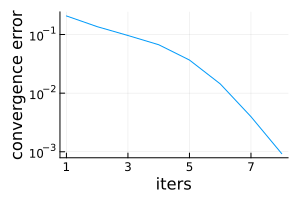

In [27]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [28]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m = mean(means(spin, bp));

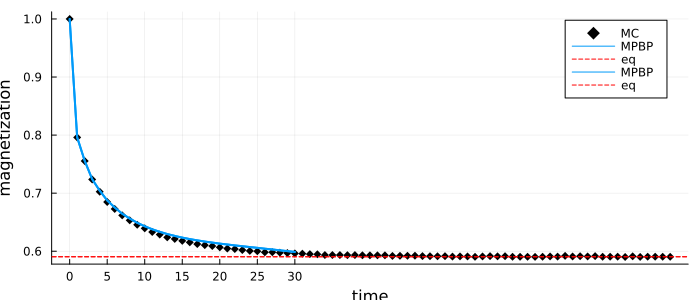

In [29]:
myblue = theme_palette(:auto)[1]
# pl = plot(0:T, m_mc, label=permutedims(["samples"; fill("", length(m_mc)-1)]), c=:gray, la=0.2)
# pl = plot()
# plot!(pl, 0:T, mean(m_mc), label="sample mean", c=:black, m=:diamond, ms=3, msc=:auto, st=:scatter)
plot!(pl, 0:T, m, lw=2, xlabel="time", ylabel="magnetization", msc=:auto, c=myblue,
    size=(500,300), xticks=0:5:T, ms=2, label="MPBP")
hline!(pl, [mean(m_mc_eq)[end]], label="eq", c=:red, ls=:dash, size=(700,300))

In [69]:
c = autocovariances(bp; showprogress=true);

Computing autocorrelations 100%|█████████████████████████| Time: 0:03:19


In [63]:
using ColorSchemes
function plot_autocovs(c, T; skip_even=true, kw...)
    step = skip_even ? 2 : 1
    us = 4:4:T
    cg = cgrad(:matter, length(us), categorical=true)
    ylabel = L"\langle x_{i}^t x_{i}^{t+\Delta t}\rangle-" * 
        L"\langle x_{i}^t\rangle\langle x_{i}^{t+\Delta t}\rangle"
    xlabel = L"\Delta t"
    pl = plot(;xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end    

plot_autocovs (generic function with 1 method)

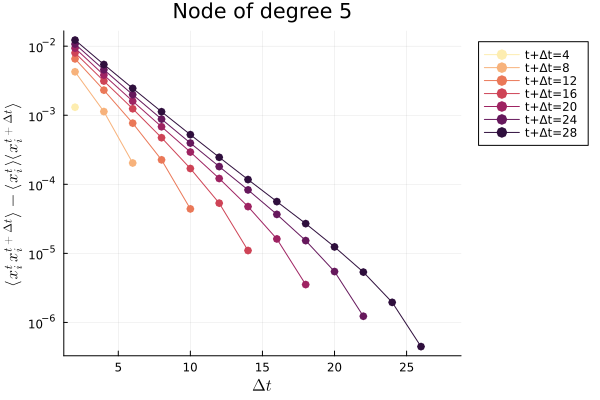

In [64]:
i = 10
ci = map(x -> x > 1e-14 ? x : NaN, c[i])
skip_even = true
pl_autocov = plot_autocovs(ci, T; skip_even, yaxis=:log10, title="Node of degree $(degree(g,i))")

In [65]:
jldsave("plot_data/glauber_RFIM.jld2"; T, m_mc_eq, m, c);